In [1]:
import torch
import numpy as np
import awkward as ak
import fastjet
import vector
import uproot
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from matplotlib.lines import Line2D

In [2]:
vector.register_awkward()

class ParticleClouds:
    def __init__(self, path, max_num_particles=128):

        data = self.read_root_file(path)
        self.max_num_particles = max_num_particles

        feats_continuous = ['part_pt_log', 'part_etarel', 'part_phirel']        
        self.continuous = torch.tensor(np.stack([ak.to_numpy(self.pad(data[feat], maxlen=max_num_particles)) for feat in feats_continuous] , axis=1))
        self.continuous = torch.permute(self.continuous, (0,2,1))

        self.log_pt = (self.continuous[...,0] - torch.mean(self.continuous[...,0])) / torch.std(self.continuous[...,0])
        self.pt = torch.exp(self.continuous[...,0])
        self.eta = self.continuous[...,1]
        self.phi = self.continuous[...,2]

        feats_discrete = ['part_isChargedHadron', 'part_isNeutralHadron', 'part_isPhoton', 'part_isElectron', 'part_isMuon', 'part_charge', 'mask']
        self.discrete = torch.tensor(np.stack([ak.to_numpy(self.pad(data[feat], maxlen=max_num_particles)) for feat in feats_discrete], axis=1)).long()
        self.discrete = torch.permute(self.discrete, (0,2,1))

        self.isChargedHadron = self.discrete[...,0]
        self.isNeutralHadron = self.discrete[...,1]
        self.isPhoton = self.discrete[...,2]
        self.isElectron = self.discrete[...,3]
        self.isMuon = self.discrete[...,4]
        self.flavor = torch.argmax(self.discrete[...,0:5], dim=2)
        self.charge = self.discrete[...,5]
        self.mask = self.discrete[...,-1]
        self.discrete = torch.concat([self.flavor.unsqueeze(dim=-1), self.charge.unsqueeze(dim=-1)], dim=2)

    def read_root_file(self, filepath):
        
        """Loads a single .root file from the JetClass dataset.
        """
        
        x = uproot.open(filepath)['tree'].arrays()
        x['part_pt'] = np.hypot(x['part_px'], x['part_py'])
        x['part_pt_log'] = np.log(x['part_pt'])
        x['part_ptrel'] = x['part_pt'] / x['jet_pt']
        x['part_deltaR'] = np.hypot(x['part_deta'], x['part_dphi'])

        p4 = vector.zip({'px': x['part_px'],
                         'py': x['part_py'],
                         'pz': x['part_pz'],
                         'energy': x['part_energy']})
        
        x['part_eta'] = p4.eta
        x['part_phi'] = p4.phi
        x['part_etarel'] = p4.eta - x['jet_eta'] 
        x['part_phirel'] = (p4.phi - x['jet_phi'] + np.pi) % (2 * np.pi) - np.pi
        x['mask'] = np.ones_like(x['part_energy']) 

        return x
    
    def pad(self, a, maxlen, value=0, dtype='float32'):
        if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
            return a
        elif isinstance(a, ak.Array):
            if a.ndim == 1:
                a = ak.unflatten(a, 1)
            a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
            return ak.values_astype(a, dtype)
        else:
            x = (np.ones((len(a), maxlen)) * value).astype(dtype)
            for idx, s in enumerate(a):
                if not len(s):
                    continue
                trunc = s[:maxlen].astype(dtype)
                x[idx, :len(trunc)] = trunc
                return x
    
    def histogram(self, features='pt', num_bins=100, density=True, use_quantiles=False):
        mask = self.mask > 0
        x = getattr(self, features)[mask]
        bins = np.quantile(x, np.linspace(0.001, 0.999, num_bins)) if use_quantiles else num_bins
        return np.histogram(x, density=density, bins=bins)[0]

    def KLmetric1D(self, feature, reference, num_bins=100, use_quantiles=True):
        h1 = self.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        h2 = reference.constituents.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        return scipy.stats.entropy(h1, h2)  

    def Wasserstein1D(self, feature, reference):
        mask = self.mask > 0
        x = getattr(self, feature)[mask]
        y = getattr(reference.constituents, feature)[mask]
        return scipy.stats.wasserstein_distance(x, y)

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, idx=None, figsize=(3,3), ax=None, **kwargs):
        mask = self.mask > 0
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        if isinstance(features, tuple):
            x = getattr(self, features[0])[mask] if idx is None else getattr(self, features[0])[:,idx]
            y = getattr(self, features[1])[mask] if idx is None else getattr(self, features[1])[:,idx]
            sns.histplot(x=x, y=y, ax=ax, **kwargs)
            ax.set_xlabel(features[0] if xlabel is None else xlabel)
            ax.set_ylabel(features[1] if ylabel is None else ylabel)
        else:
            x = getattr(self, features)[mask] if idx is None else getattr(self, features)[:,idx]
            sns.histplot(x=x, element="step", ax=ax, **kwargs) 
            ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def display_cloud(self, idx, ax=None, figsize=(3,3) , facecolor='whitesmoke'):
            eta = self.eta[idx].numpy()
            phi = self.phi[idx].numpy()
            pt = self.pt[idx].numpy()
            flavor = self.flavor[idx].numpy()
            charge = self.charge[idx].numpy()
            mask = list(pt > 0)

            pt = pt[mask] 
            eta = eta[mask] 
            phi = phi[mask] 
            flavor = flavor[mask]
            charge = charge[mask]

            if ax is None: _, ax = plt.subplots(figsize=figsize)            

            ax.scatter(eta[(flavor==0) & (charge<0)], phi[(flavor==0) & (charge<0)], marker='^', s=3*pt[(flavor==0) & (charge<0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
            ax.scatter(eta[(flavor==0) & (charge>0)], phi[(flavor==0) & (charge>0)], marker='v', s=3*pt[(flavor==0) & (charge>0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
            ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=3*pt[flavor==1], color='darkred', alpha=0.5,  label=r'$h^{0}$')
            ax.scatter(eta[flavor==2], phi[flavor==2], marker='o', s=3*pt[flavor==2], color='gold', alpha=0.5, label=r'$\gamma$')
            ax.scatter(eta[(flavor==3) & (charge<0)], phi[(flavor==3) & (charge<0)], marker='^', s=3*pt[(flavor==3) & (charge<0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
            ax.scatter(eta[(flavor==3) & (charge>0)], phi[(flavor==3) & (charge>0)], marker='v', s=3*pt[(flavor==3) & (charge>0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
            ax.scatter(eta[(flavor==4) & (charge<0)], phi[(flavor==4) & (charge<0)], marker='^', s=3*pt[(flavor==4) & (charge<0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')
            ax.scatter(eta[(flavor==4) & (charge>0)], phi[(flavor==4) & (charge>0)], marker='v', s=3*pt[(flavor==4) & (charge>0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')

            # Define custom legend markers
            h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkblue', linestyle='None')
            h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkred', linestyle='None')
            h3 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
            h4 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='green', linestyle='None')
            h5 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='purple', linestyle='None')

            plt.legend([h1, h2, h3, h4, h5], 
                    [r'$h^{\pm}$', r'$h^{0}$', r'$\gamma$', '$e^{\pm}$', '$\mu^{\pm}$'], 
                    loc="upper right", 
                    markerscale=2, 
                    scatterpoints=1, 
                    fontsize=7,  
                    frameon=False,
                    ncol=8,
                    bbox_to_anchor=(0.625, 1.11),
                    handletextpad=-0.5,  
                    columnspacing=.1) 

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(facecolor)  # Set the same color for the axis background


In [3]:
class NoiseClouds:
    def __init__(self, num_clouds, num_particles=128):

        self.num_particles = num_particles
        self.continuous = torch.tensor(np.random.normal(size=(num_clouds, num_particles, 3)))
        self.pt = torch.tensor(np.random.lognormal(size=(num_clouds, num_particles)))
        self.log_pt = self.continuous[...,0]
        self.eta = self.continuous[...,1]
        self.phi = self.continuous[...,2]

        flavor = np.random.choice([0,1,2,3,4], size=(num_clouds, num_particles))
        charge = np.random.choice([-1, 1], size=(num_clouds, num_particles))
        charge = np.where((flavor==1) | (flavor==2), 0, charge)
        self.flavor = torch.tensor(flavor).long()
        self.charge = torch.tensor(charge).long()
        self.discrete = torch.concat([self.flavor.unsqueeze(dim=-1), self.charge.unsqueeze(dim=-1)], dim=2)

        self.isChargedHadron = torch.zeros((num_clouds, num_particles))
        self.isNeutralHadron = torch.zeros((num_clouds, num_particles))
        self.isPhoton = torch.zeros((num_clouds, num_particles))
        self.isElectron = torch.zeros((num_clouds, num_particles))
        self.isMuon = torch.zeros((num_clouds, num_particles))

        self.isChargedHadron[self.flavor==0] = 1
        self.isNeutralHadron[self.flavor==1] = 1
        self.isPhoton[self.flavor==2] = 1
        self.isElectron[self.flavor==3] = 1
        self.isMuon[self.flavor==4] = 1
        self.mask = torch.ones_like(self.charge)

        
    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, idx=None, figsize=(3,3), ax=None, **kwargs):
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        if isinstance(features, tuple):
            x = getattr(self, features[0]) if idx is None else getattr(self, features[0])[:,idx]
            y = getattr(self, features[1]) if idx is None else getattr(self, features[1])[:,idx]
            sns.histplot(x=x, y=y, ax=ax, **kwargs)
            ax.set_xlabel(features[0] if xlabel is None else xlabel)
            ax.set_ylabel(features[1] if ylabel is None else ylabel)
        else:
            x = getattr(self, features) if idx is None else getattr(self, features)[:,idx]
            sns.histplot(x=x.numpy(), element="step", ax=ax, **kwargs) 
            ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def display_cloud(self, idx, ax=None, figsize=(3,3) , facecolor='whitesmoke'):
            eta = self.eta[idx].flatten().numpy()
            phi = self.phi[idx].flatten().numpy()
            pt = self.pt[idx].flatten().numpy()
            flavor = self.flavor[idx].flatten().numpy()
            charge = self.charge[idx].flatten().numpy()

            if ax is None: _, ax = plt.subplots(figsize=figsize)            

            ax.scatter(eta[(flavor==0) & (charge<0)], phi[(flavor==0) & (charge<0)], marker='^', s=3*pt[(flavor==0) & (charge<0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
            ax.scatter(eta[(flavor==0) & (charge>0)], phi[(flavor==0) & (charge>0)], marker='v', s=3*pt[(flavor==0) & (charge>0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
            ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=3*pt[flavor==1], color='darkred', alpha=0.5,  label=r'$h^{0}$')
            ax.scatter(eta[flavor==2], phi[flavor==2], marker='o', s=3*pt[flavor==2], color='gold', alpha=0.5, label=r'$\gamma$')
            ax.scatter(eta[(flavor==3) & (charge<0)], phi[(flavor==3) & (charge<0)], marker='^', s=3*pt[(flavor==3) & (charge<0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
            ax.scatter(eta[(flavor==3) & (charge>0)], phi[(flavor==3) & (charge>0)], marker='v', s=3*pt[(flavor==3) & (charge>0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
            ax.scatter(eta[(flavor==4) & (charge<0)], phi[(flavor==4) & (charge<0)], marker='^', s=3*pt[(flavor==4) & (charge<0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')
            ax.scatter(eta[(flavor==4) & (charge>0)], phi[(flavor==4) & (charge>0)], marker='v', s=3*pt[(flavor==4) & (charge>0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')

            # Define custom legend markers
            h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkblue', linestyle='None')
            h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkred', linestyle='None')
            h3 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
            h4 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='green', linestyle='None')
            h5 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='purple', linestyle='None')

            plt.legend([h1, h2, h3, h4, h5], 
                    [r'$h^{\pm}$', r'$h^{0}$', r'$\gamma$', '$e^{\pm}$', '$\mu^{\pm}$'], 
                    loc="upper right", 
                    markerscale=2, 
                    scatterpoints=1, 
                    fontsize=7,  
                    frameon=False,
                    ncol=8,
                    bbox_to_anchor=(0.625, 1.11),
                    handletextpad=-0.5,  
                    columnspacing=.1) 

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(facecolor)  # Set the same color for the axis background


In [4]:
tops = ParticleClouds('/home/df630/CMB/data/JetClass/TTBar_000.root')
noise = NoiseClouds(100000)

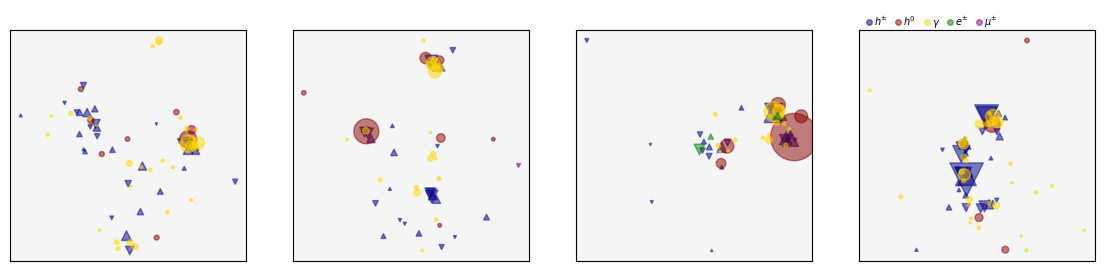

<Figure size 640x480 with 0 Axes>

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(14,3)) 
tops.display_cloud(idx=0, ax=ax[0])
tops.display_cloud(idx=1, ax=ax[1])
tops.display_cloud(idx=2, ax=ax[2])
tops.display_cloud(idx=3, ax=ax[3])
plt.show()
plt.tight_layout()

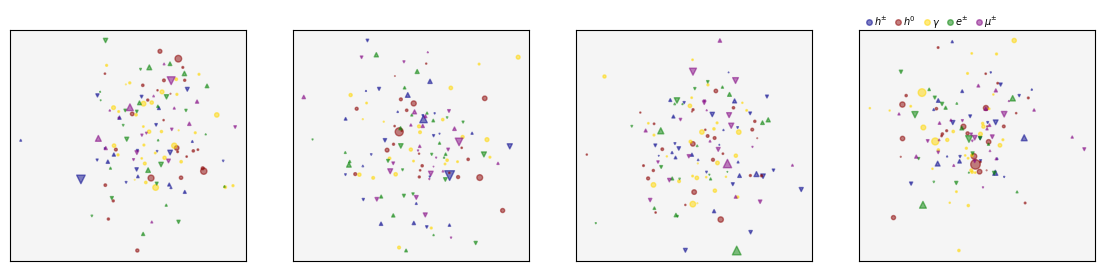

<Figure size 640x480 with 0 Axes>

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(14,3)) 
noise.display_cloud(idx=0, ax=ax[0])
noise.display_cloud(idx=1, ax=ax[1])
noise.display_cloud(idx=2, ax=ax[2])
noise.display_cloud(idx=3, ax=ax[3])
plt.show()
plt.tight_layout()

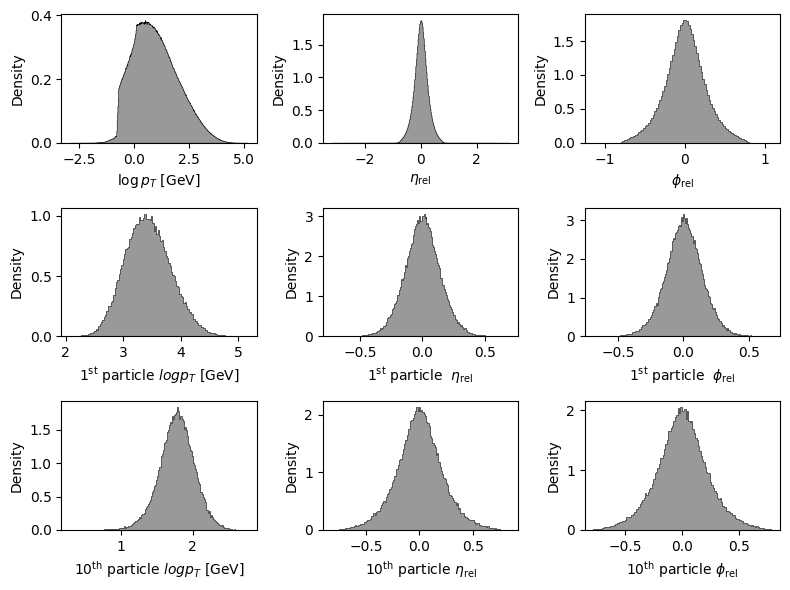

In [33]:
_, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,6))

plot_args = {'alpha': 0.4,
             'lw': 0.4, 
             'log_scale': (False, False), 
             'color': 'k',
             'stat': 'density'}

tops.histplot('log_pt', xlabel=r'$\log p_T$ [GeV]',  ax=ax[0,0], label='top', **plot_args)
tops.histplot('eta', xlabel=r'$\eta_{\rm rel}$', binwidth=0.02, ax=ax[0,1], **plot_args)
tops.histplot('phi', xlabel=r'$\phi_{\rm rel}$', binwidth=0.02, ax=ax[0,2], **plot_args)

tops.histplot('log_pt', idx=0, xlabel=r'1$^{\rm st}$ particle $log p_T$ [GeV]', ax=ax[1,0], **plot_args)
tops.histplot('eta', idx=0, xlabel=r'1$^{\rm st}$ particle  $\eta_{\rm rel}$', ax=ax[1,1], **plot_args)
tops.histplot('phi', idx=0, xlabel=r'1$^{\rm st}$ particle  $\phi_{\rm rel}$',  ax=ax[1,2], **plot_args)

tops.histplot('log_pt', idx=10, xlabel=r'10$^{\rm th}$ particle $log p_T$ [GeV]', ax=ax[2,0], **plot_args)
tops.histplot('eta', idx=10, xlabel=r'10$^{\rm th}$ particle $\eta_{\rm rel}$', ax=ax[2,1], **plot_args)
tops.histplot('phi', idx=10, xlabel=r'10$^{\rm th}$ particle $\phi_{\rm rel}$', ax=ax[2,2], **plot_args)

plt.tight_layout()

In [ ]:
import torch
import numpy as np
from dataclasses import dataclass
from cmb.data.utils import AbstractDataClass
from torchvision import datasets, transforms


class JetClassDataClass:
    def __init__(self, config: dataclass, threshold: float = 0.5):
        self.config = config

        if self.config.DATA_TARGET == 'tops':
            self.target = ParticleClouds('/home/df630/CMB/data/JetClass/TTBar_000.root')
            
        if self.config.DATA_SOURCE == 'noise':
            self.source = NoiseClouds()

